In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from scipy.spatial import KDTree
from matplotlib import colors

In [2]:
# Custom code to load .list files
import stuff

In [3]:
stars, galaxies = stuff.parse_stuff_list('/home/aalvarez/Work/Data/sim09/sim09_r.list')

In [4]:
img = fits.open('/home/aalvarez/Work/Data/sim09/sim09_r_05.fits')[0]

We have now the baseline. We train a KDTree with their coordinates, so we can cross-reference

In [5]:
stars_coords = np.stack([stars.ra, stars.dec]).T
galaxies_coords = np.stack([galaxies.ra, galaxies.dec]).T
all_coords = np.append(stars_coords, galaxies_coords, axis=0)
all_kdtree = KDTree(all_coords)

n_stars = len(stars)
n_galaxies = len(galaxies)

Load the run with and without variable PSF

In [6]:
variable_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_vpsf/sexpp.out.fits')
constant_catalog = Table.read('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09/sexpp.out.fits')

Compute magnitudes

In [7]:
# This comes from sim09_r_sky.conf
mag_zeropoint = 26.
exp_time = 300.

In [8]:
variable_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(variable_catalog['pmf_total_flux'] / exp_time)
constant_catalog['mag'] = mag_zeropoint - 2.5 * np.log10(constant_catalog['pmf_total_flux'] / exp_time)

## Residuals

In [9]:
variable_residuals = fits.open('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_vpsf/check_residual.fits')
constant_residuals = fits.open('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09/check_residual.fits')

<IPython.core.display.Javascript object>


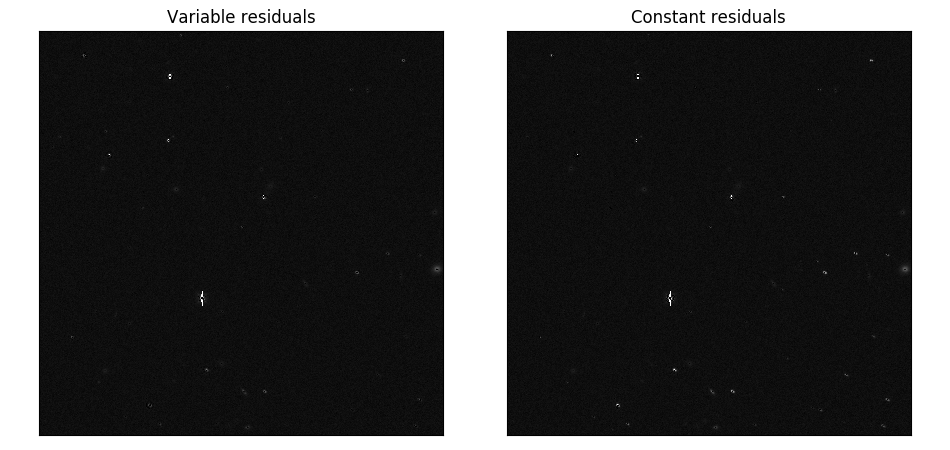

In [10]:
cmap = plt.get_cmap('Greys_r')
norm = colors.SymLogNorm(1200)
norm.autoscale(img.data)

plt.figure(figsize=(9.5, 4.5))

plt.subplot(121)
plt.imshow(variable_residuals[0].data, cmap=cmap, norm=norm)
plt.title('Variable residuals')
_ = plt.xticks([])
_ = plt.yticks([])

plt.subplot(122)
plt.imshow(constant_residuals[0].data, cmap=cmap, norm=norm)
plt.title('Constant residuals')
_ = plt.xticks([])
_ = plt.yticks([])

plt.tight_layout()

## Compare results for stars
Stars are points, so the error should be influenced only by the variable PSF. For each entry on the result catalog, we look for the nearest original source. If it happens to be a galaxy, we drop it.

In [11]:
def get_closest_stars(catalog):
    distances = []
    index_c = []
    index_s = []
    for i, e in enumerate(catalog):
        d, s = all_kdtree.query([e['pmf_alpha'], e['pmf_delta']], 1)
        if s < n_stars:
            distances.append(d)
            index_c.append(i)
            index_s.append(s)
    return {
        'dist': np.array(distances),
        'catalog': np.array(index_c),
        'star': np.array(index_s),
    }

In [12]:
stars_variable_closest = get_closest_stars(variable_catalog)
stars_constant_closest = get_closest_stars(constant_catalog)

In [13]:
print("Variable PSF | Number of sources found:", len(variable_catalog))
print("Constant PSF | Number of sources found:", len(constant_catalog))
print("Variable PSF | Number of stars found:", len(stars_variable_closest['dist']))
print("Constant PSF | Number of stars found:", len(stars_constant_closest['dist']))

Variable PSF | Number of sources found: 346
Constant PSF | Number of sources found: 346
Variable PSF | Number of stars found: 186
Constant PSF | Number of stars found: 186


In [14]:
def plot_stats(ax, data):
    ax.text(
        0.7, 0.7,
        '$\mu$: {:.3e}\n$\sigma$: {:.3e}\n$\%_{{50}}$: {:.3e}\n$\%_{{95}}$: {:.3e}'.format(
            np.average(data),
            np.std(data),
            np.median(data),
            np.percentile(data, 95)
        ),
        transform=ax.transAxes
    )

<IPython.core.display.Javascript object>


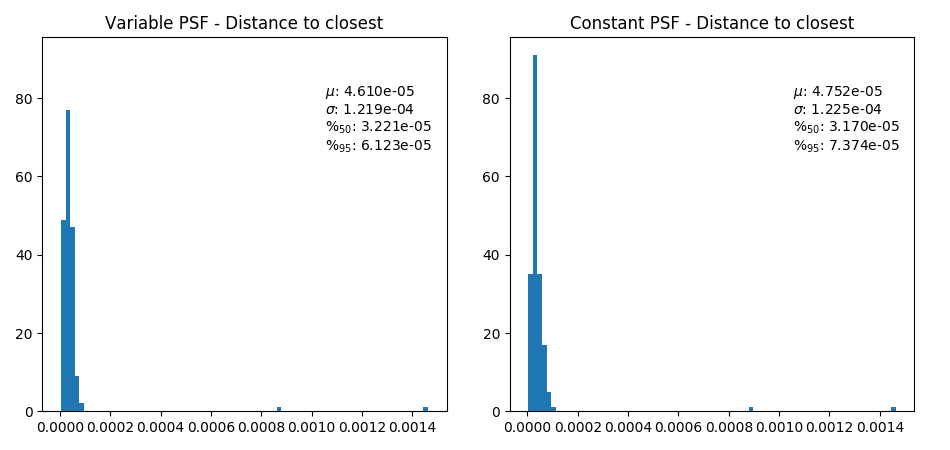

In [15]:
plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(stars_variable_closest['dist'], 80)
plot_stats(ax1, stars_variable_closest['dist'])
_ = ax1.set_title('Variable PSF - Distance to closest')

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.hist(stars_constant_closest['dist'], 80)
plot_stats(ax2, stars_constant_closest['dist'])
_ = ax2.set_title('Constant PSF - Distance to closest')

plt.tight_layout()

Overall, computed sources are closer to their closest original star with the variable PSF.

### Magnitudes

In [16]:
stars_variable_catalog = variable_catalog[stars_variable_closest['catalog']]
stars_constant_catalog = constant_catalog[stars_constant_closest['catalog']]
stars_variable_mag_diff = stars_variable_catalog['mag'] - stars[stars_variable_closest['star']].mag
stars_constant_mag_diff = stars_constant_catalog['mag'] - stars[stars_constant_closest['star']].mag

<IPython.core.display.Javascript object>


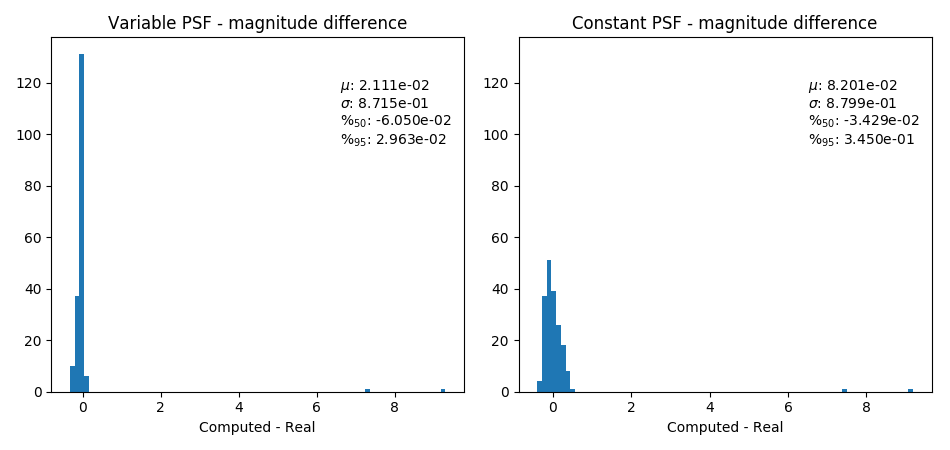

In [17]:
plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.hist(stars_variable_mag_diff, 80)
ax1.set_xlabel('Computed - Real')
plot_stats(ax1, stars_variable_mag_diff)
ax1.set_title('Variable PSF - magnitude difference')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
ax2.hist(stars_constant_mag_diff, 80)
ax2.set_xlabel('Computed - Real')
plot_stats(ax2, stars_constant_mag_diff)
_ = ax2.set_title('Constant PSF - magnitude difference')

plt.tight_layout()

<IPython.core.display.Javascript object>


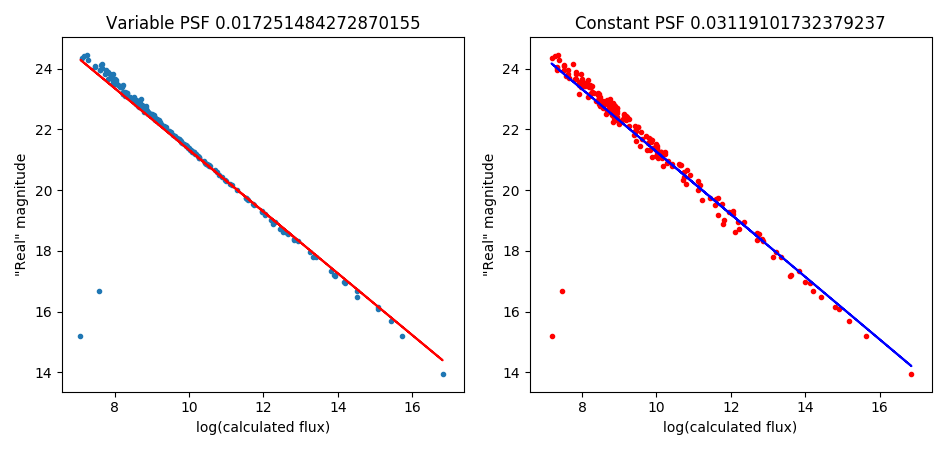

In [18]:
variable_predicted_flux_log = np.log(variable_catalog[stars_variable_closest['catalog']]['pmf_total_flux'])
variable_simulation_mag = stars[stars_variable_closest['star']].mag

variable_fit = np.polyfit(variable_predicted_flux_log, variable_simulation_mag, 1)
variable_fn = np.poly1d(variable_fit)

constant_predicted_flux_log = np.log(constant_catalog[stars_constant_closest['catalog']]['pmf_total_flux'])
constant_simulation_mag = stars[stars_constant_closest['star']].mag

constant_fit = np.polyfit(constant_predicted_flux_log, constant_simulation_mag, 1)
constant_fn = np.poly1d(constant_fit)

plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(
    variable_predicted_flux_log,
    variable_simulation_mag,
    marker='.'
)
ax1.plot(variable_predicted_flux_log, variable_fn(variable_predicted_flux_log), c='r')
ax1.set_xlabel('log(calculated flux)')
ax1.set_ylabel('"Real" magnitude')
ax1.set_title('Variable PSF {}'.format(-1-variable_fit[0]))

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.scatter(
    constant_predicted_flux_log,
    constant_simulation_mag,
    marker='.', c='r'
)
ax2.plot(constant_predicted_flux_log, constant_fn(constant_predicted_flux_log), c='b')
ax2.set_xlabel('log(calculated flux)')
ax2.set_ylabel('"Real" magnitude')
ax2.set_title('Constant PSF {}'.format(-1-constant_fit[0]))

plt.tight_layout()

<IPython.core.display.Javascript object>


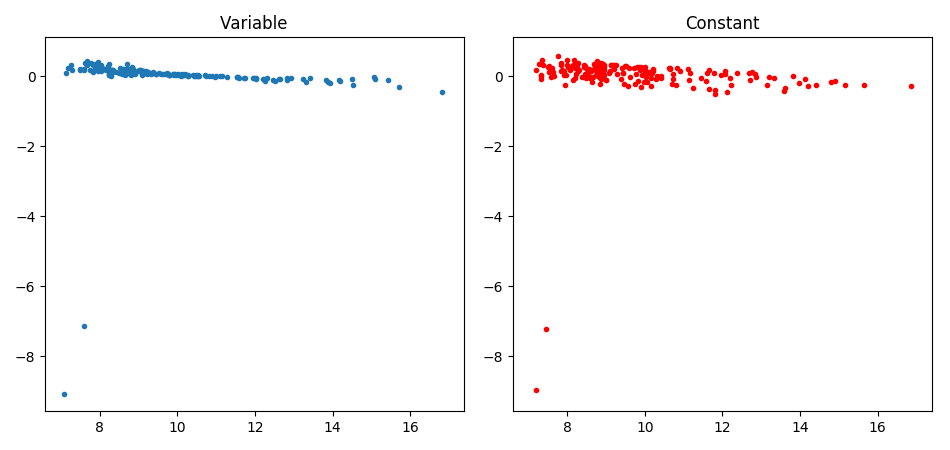

In [19]:
plt.figure(figsize=(9.5, 4.5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(
    variable_predicted_flux_log,
    variable_simulation_mag - variable_fn(variable_predicted_flux_log),
    marker='.'
)
ax1.set_title('Variable')

ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.scatter(
    constant_predicted_flux_log,
    constant_simulation_mag - constant_fn(constant_predicted_flux_log),
    marker='.', c='r'
)
ax2.set_title('Constant')

plt.tight_layout()

## Who are the outliers?

In [20]:
def get_outliers(mag_diff, closest, catalog, p=95.):
    outliers_selector = mag_diff > np.percentile(mag_diff, p)
    outliers_closest = stars[closest['star'][outliers_selector]]
    outliers = catalog[closest['catalog'][outliers_selector]]
    return outliers, outliers_closest

In [21]:
variable_outliers, variable_outliers_closest = get_outliers(
    stars_variable_mag_diff, stars_variable_closest, variable_catalog
)
constant_outliers, constant_outliers_closest = get_outliers(
    stars_constant_mag_diff, stars_constant_closest, constant_catalog
)

In [22]:
wcs = WCS(img.header)

In [23]:
model_img = fits.open('/home/aalvarez/Work/Projects/sextractorxx/tests/sim09_vpsf/check_modelfitting.fits')[0]

In [24]:
found_stars = variable_catalog[stars_variable_closest['catalog']]
found_wcs = wcs.all_world2pix(found_stars['pmf_alpha'], found_stars['pmf_delta'], 0)
outliers_wcs = wcs.all_world2pix(variable_outliers['pmf_alpha'], variable_outliers['pmf_delta'], 0)
closest_wcs = wcs.all_world2pix(variable_outliers_closest.ra, variable_outliers_closest.dec, 0)
stars_wcs = wcs.all_world2pix(stars.ra, stars.dec, 0)
galaxies_wcs = wcs.all_world2pix(galaxies.ra, galaxies.dec, 0)

<IPython.core.display.Javascript object>


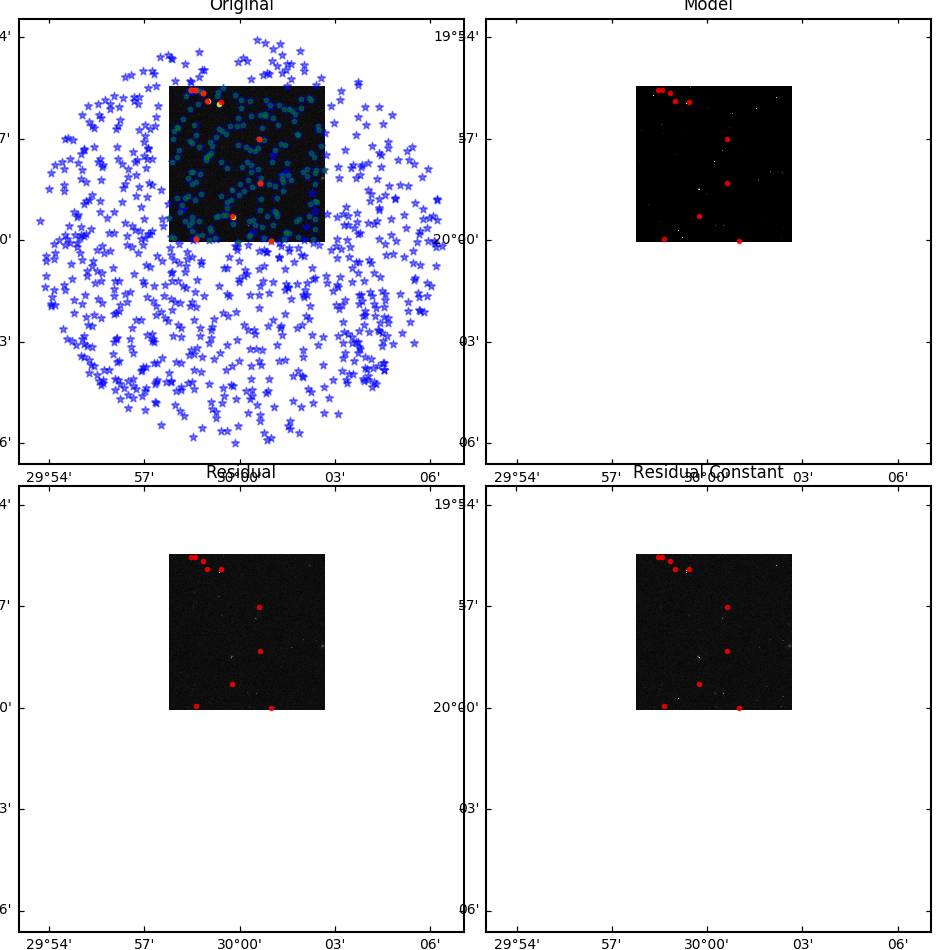

In [25]:
plt.figure(figsize=(9.5, 9.5))

ax1 = plt.subplot(2, 2, 1, projection=wcs)
ax1.imshow(img.data, cmap=cmap, norm=norm)
ax1.scatter(stars_wcs[0], stars_wcs[1], marker='*', alpha=0.5, c='blue')
ax1.scatter(found_wcs[0], found_wcs[1], marker='.', alpha=0.5, c='green')
ax1.scatter(closest_wcs[0], closest_wcs[1], marker='.', alpha=0.8, c='yellow')
ax1.scatter(outliers_wcs[0], outliers_wcs[1], marker='.', alpha=0.8, c='red')

ax1.set_title('Original')

ax2 = plt.subplot(2, 2, 2, projection=wcs, sharex=ax1, sharey=ax1)
ax2.imshow(model_img.data, cmap=cmap, norm=norm)
ax2.scatter(outliers_wcs[0], outliers_wcs[1], marker='.', alpha=0.8, c='red')
ax2.set_title('Model')

ax3 = plt.subplot(2, 2, 3, projection=wcs, sharex=ax1, sharey=ax1)
ax3.imshow(variable_residuals[0].data, cmap=cmap, norm=norm)
ax3.scatter(outliers_wcs[0], outliers_wcs[1], marker='.', alpha=0.8, c='red')
ax3.set_title('Residual')

ax4 = plt.subplot(2, 2, 4, projection=wcs, sharex=ax1, sharey=ax1)
ax4.imshow(constant_residuals[0].data, cmap=cmap, norm=norm)
ax4.scatter(outliers_wcs[0], outliers_wcs[1], marker='.', alpha=0.8, c='red')
ax4.set_title('Residual Constant')

plt.tight_layout()

* **<span style='color: blue'>Blue star</span>**: Star entry on the simulation `.list` file
* **<span style='color: green'>Green dot</span>**: Star found by sextractor
* **<span style='color: red'>Red dot</span>**: Star found by sextractor (outliers)
* **<span style='color: orange'>Yellow dot</span>**: Outliers closest 'real' star